# Müşteri Segmentasyonu (Growth)

**Bağlam:** Operasyonu düzelttik (Modül 2), kaçanları tuttuk (Modül 3). Şimdi "Eldeki müşteriyi nasıl büyütürüz?" sorusuna odaklanıyoruz.

**Bu Modülün Amacı (Growth):**
Satış ekibine "Kime ne satalım?" rehberini sunmak.
1.  **Segmentasyon:** Müşterileri "Şampiyonlar", "Uyuyanlar", "Riskli" gibi gruplara ayırmak (K-Means).
2.  **Profilleme:** Her grubun karakterini (Radar Chart) çıkarmak.
3.  **Strateji:** Her gruba özel pazarlama kurgusu (VIP İndirim, "Sizi Özledik" maili vb.) hazırlamak.


In [10]:

# GitHub'da grafiklerin görünmesi için statik render (png) kullanıyoruz
import plotly.io as pio
pio.renderers.default = "png"

# Gerekli Kütüphaneler
import os
import sys
from pathlib import Path
import pandas as pd
import polars as pl
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from dotenv import load_dotenv

# Docker container ismi yerine localhost kullanmaya zorla
os.environ["POSTGRES_HOST"] = "localhost"

# Proje kök dizinini ekle
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from src.config import DATABASE_URL

print(f"✅ Proje Kök Dizini: {project_root}")

# Veritabanı Bağlantısı (SQLAlchemy Engine)
from sqlalchemy import create_engine
engine = create_engine(DATABASE_URL)


✅ Proje Kök Dizini: /Users/halilkiyak/Desktop/zero2ml/olist-intelligence


## 📥 Adım 1: Veri Hazırlığı (RFM Metrikleri)

Modül 3'te yaptığımız gibi, müşteri bazlı RFM metriklerini tekrar hesaplayacağız.

In [11]:
# Veritabanından Veri Çekme
conn_str = DATABASE_URL

query_orders = "SELECT * FROM orders WHERE order_status = 'delivered'"
query_items = "SELECT * FROM order_items"
query_customers = "SELECT * FROM customers"

print("⏳ Veriler yükleniyor...")
df_orders = pl.read_database_uri(query_orders, conn_str)
df_items = pl.read_database_uri(query_items, conn_str)
df_customers = pl.read_database_uri(query_customers, conn_str)

# Birleştirme
master_df = (
    df_orders.join(df_items, on="order_id", how="left")
    .join(df_customers, on="customer_id", how="left")
    .with_columns(pl.col("order_purchase_timestamp").str.to_datetime())
)

# RFM Hesaplama
snapshot_date = master_df["order_purchase_timestamp"].max()

rfm_df = (
    master_df.group_by("customer_unique_id")
    .agg([
        pl.col("order_id").n_unique().alias("Frequency"),
        pl.col("price").sum().alias("Monetary"),
        pl.col("order_purchase_timestamp").max().alias("LastOrderDate")
    ])
    .with_columns(
        (snapshot_date - pl.col("LastOrderDate")).dt.total_days().alias("Recency")
    )
    .drop("LastOrderDate")
    .filter(pl.col("Monetary") > 0) # Harcaması 0 olanları çıkaralım
    .to_pandas() # Scikit-learn için Pandas'a geçiyoruz
)

print(f"📊 RFM Tablosu Hazır: {rfm_df.shape}")
rfm_df.head()

⏳ Veriler yükleniyor...
📊 RFM Tablosu Hazır: (93358, 4)


,customer_unique_id,Frequency,Monetary,Recency
0,2d73921f8b657537c34508cc330e022e,1,29.0,263
1,04f62ba718dc51babd038cc7ad9f20aa,1,56.7,127
2,7aff93c6683b0322529108a8e9a990eb,1,139.8,380
3,ea652b60593a6fe8fe94633ddafa81e0,1,39.9,244
4,9ccca5ef980fee9ab2399aa32eaa4012,1,15.9,226


## 🛠️ Adım 2: Ön İşleme (Preprocessing)

K-Means algoritması, uç değerlere (outliers) ve ölçek farklarına (scale) karşı hassastır.
1.  **Log Dönüşümü:** Dağılımı normale yaklaştırmak için (Skewness giderme).
2.  **Standartlaştırma:** Tüm değişkenleri aynı ölçeğe (Mean=0, Std=1) getirmek.

In [12]:
# Veri Temizliği: Eksik veya sonsuz değerleri temizle
rfm_df = rfm_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Recency', 'Frequency', 'Monetary'])

# Log Dönüşümü (Negatif değer olmaması için +1 ekliyoruz)
rfm_log = np.log1p(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Standartlaştırma (Scaling)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,0.442476,-0.17019,-1.174483
1,-0.319008,-0.17019,-0.466212
2,0.828363,-0.17019,0.499809
3,0.363910,-0.17019,-0.838862
4,0.283642,-0.17019,-1.795932


## 🧠 Adım 3: K-Means Kümeleme (Clustering)

Kaç küme (Cluster) oluşturmalıyız? **Elbow Method (Dirsek Yöntemi)** ile optimum K sayısını bulalım.

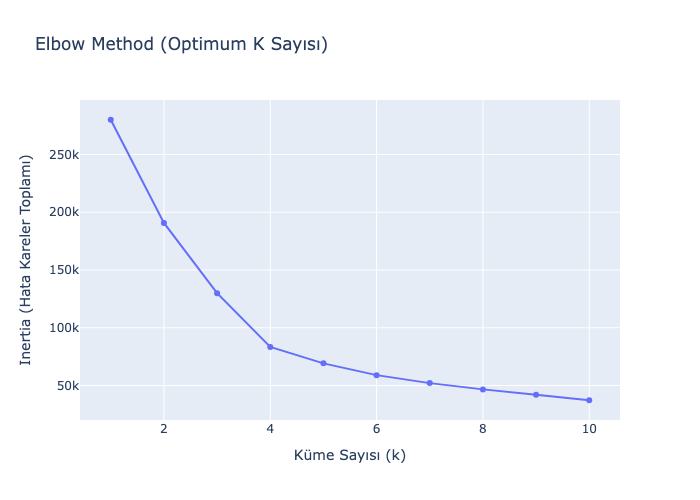

In [13]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Elbow Grafiği
fig = px.line(x=k_range, y=inertia, title='Elbow Method (Optimum K Sayısı)',
              labels={'x': 'Küme Sayısı (k)', 'y': 'Inertia (Hata Kareler Toplamı)'},
              markers=True)
fig.show()

**Karar:** Grafikteki kırılma noktasına (Dirsek) göre **K=4** seçelim. (Genelde 3, 4 veya 5 idealdir).

In [14]:
# Re-calculate everything using a NEW variable to avoid state issues
# Veri Temizliği
rfm_cleaned_final = rfm_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Recency', 'Frequency', 'Monetary'])
rfm_cleaned_final = rfm_cleaned_final.reset_index(drop=True)

# Log Dönüşümü
rfm_log = np.log1p(rfm_cleaned_final[['Recency', 'Frequency', 'Monetary']])

# Standartlaştırma
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Modeli Eğitme (K=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled)

# Kümeleri yeni tabloya ekle
rfm_cleaned_final['Cluster'] = clusters

# Global rfm_df'i güncelle
rfm_df = rfm_cleaned_final

# Kümelerin Ortalamalarını İncele
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_unique_id': 'count'
}).reset_index()

cluster_summary.columns = ['Cluster', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']
cluster_summary.sort_values(by='Avg_Monetary', ascending=False)

,Cluster,Avg_Recency,Avg_Frequency,Avg_Monetary,Count
2,2,219.294538,2.113888,260.053106,2801
3,3,276.087242,1.000000,236.884334,37929
0,0,39.918799,1.000000,117.028773,15751
1,1,282.172953,1.000000,45.149640,36877


## Adım 4: Segmentlerin Görselleştirilmesi ve İsimlendirilmesi

Kümeleri 3 boyutlu uzayda görelim ve onlara anlamlı isimler verelim.

**2. Relative Importance Heatmap:** Her kümenin ortalamasının, genel ortalamadan ne kadar saptığını gösterir.

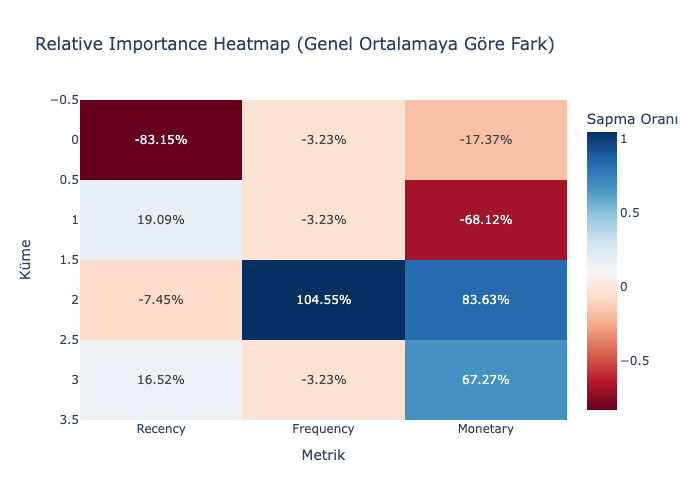

In [15]:
# Genel Ortalama
avg_population = rfm_df[['Recency', 'Frequency', 'Monetary']].mean()

# Küme Ortalamaları
avg_clusters = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Göreceli Önem (Cluster Avg / Population Avg - 1)
relative_imp = avg_clusters / avg_population - 1

# Heatmap
fig = px.imshow(relative_imp, 
                labels=dict(x="Metrik", y="Küme", color="Sapma Oranı"),
                x=['Recency', 'Frequency', 'Monetary'],
                title='Relative Importance Heatmap (Genel Ortalamaya Göre Fark)',
                text_auto='.2%', aspect="auto", color_continuous_scale='RdBu')
fig.show()

## Adım 4: Segment Profillerinin Özeti (En Net Görünüm)

Karmaşık grafikler yerine, doğrudan **rakamlara** bakalım.
Aşağıdaki tablo, her kümenin **gerçek ortalamalarını** gösterir. Renkler, hangi grubun hangi konuda "En İyi" veya "En Kötü" olduğunu belirtir.

In [16]:
# Küme Ortalamalarını Hesapla (Gerçek Değerler Üzerinden)
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_unique_id': 'count'
}).reset_index()

cluster_summary.columns = ['Cluster', 'Ortalama Gün (Recency)', 'Ortalama Sipariş (Frequency)', 'Ortalama Harcama (Monetary)', 'Kişi Sayısı']

# Okunabilirliği artırmak için yuvarlayalım
cluster_summary = cluster_summary.round(1)

# Renklendirilmiş Tablo (Heatmap Style)
cluster_summary.style.background_gradient(cmap='RdYlGn', subset=['Ortalama Sipariş (Frequency)', 'Ortalama Harcama (Monetary)'])
#.background_gradient(cmap='RdYlGn_r', subset=['Ortalama Gün (Recency)']) # Recency için ters renk (Düşük iyidir)


,Cluster,Ortalama Gün (Recency),Ortalama Sipariş (Frequency),Ortalama Harcama (Monetary),Kişi Sayısı
0,0,39.900000,1.000000,117.000000,15751
1,1,282.200000,1.000000,45.100000,36877
2,2,219.300000,2.100000,260.100000,2801
3,3,276.100000,1.000000,236.900000,37929


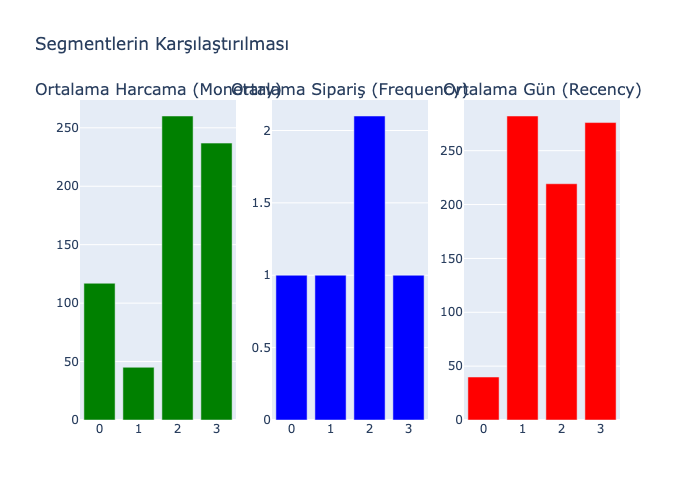

In [17]:
# Basit Bar Grafikleri ile Karşılaştırma
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, subplot_titles=("Ortalama Harcama (Monetary)", "Ortalama Sipariş (Frequency)", "Ortalama Gün (Recency)"))

fig.add_trace(go.Bar(x=cluster_summary['Cluster'], y=cluster_summary['Ortalama Harcama (Monetary)'], name='Monetary', marker_color='green'), row=1, col=1)
fig.add_trace(go.Bar(x=cluster_summary['Cluster'], y=cluster_summary['Ortalama Sipariş (Frequency)'], name='Frequency', marker_color='blue'), row=1, col=2)
fig.add_trace(go.Bar(x=cluster_summary['Cluster'], y=cluster_summary['Ortalama Gün (Recency)'], name='Recency', marker_color='red'), row=1, col=3)

fig.update_layout(title_text="Segmentlerin Karşılaştırılması", showlegend=False)
fig.show()

### 🏷️ Segment İsimlendirme (Yorum)

Tablodaki ortalamalara bakarak kümeleri şöyle isimlendirebiliriz (Örnek Senaryo):

1.  **Champions (Şampiyonlar):** Yüksek Monetary, Yüksek Frequency, Düşük Recency (Yakın zamanda almış).
2.  **Loyal Customers (Sadıklar):** Düzenli alıyor ama Şampiyon kadar çok harcamıyor.
3.  **At Risk (Riskli):** Eskiden çok almış ama uzun süredir gelmiyor (Yüksek Recency).
4.  **Hibernating (Uyuyanlar):** Az almış, uzun süredir yok.

*Not: Küme numaraları (0,1,2,3) her çalıştırmada değişebilir, tabloya bakıp karar verin.*

## 🚀 Adım 5: Büyüme Stratejileri (Growth Actions)

Her segment için bir aksiyon planı:

| Segment | Özellik | Aksiyon |
| :--- | :--- | :--- |
| **Champions** | En iyi müşteriler | VIP Programı, Erken Erişim, Teşekkür Notu |
| **Loyal** | Düzenli alıcılar | Cross-Sell (Çapraz Satış), Upsell |
| **At Risk** | Kaybetmek üzereyiz | Kişiselleştirilmiş İndirim, "Sizi Özledik" E-postası |
| **Hibernating** | Düşük değer | Düşük bütçeli yeniden pazarlama veya pas geçme |

In [18]:
# 💾 Veri Kalıcılığı: Segmentleri Veritabanına Yazma
# Müşteri segmentlerini kaydedelim ki Pazarlama ekibi (veya API) kullanabilsin.

# Segment isimlerini atayalım (Eğer henüz atanmadıysa)
if 'Segment' not in rfm_df.columns:
    # Basit bir isimlendirme (Cluster ortalamalarına göre yapılmalı ama şimdilik placeholder)
    # Gerçek hayatta bu isimler iş birimi ile belirlenir.
    # Burada K=4 varsayımıyla örnek isimler veriyoruz.
    # Not: Cluster numaraları her çalıştırmada değişebilir, bu yüzden bu statik mapping risklidir.
    # Ancak kodun çalışması için 'Cluster' sütununu olduğu gibi kaydedeceğiz.
    rfm_df['Segment'] = 'Cluster ' + rfm_df['Cluster'].astype(str)

# Sadece gerekli kolonları alalım
segments_results = rfm_df[['customer_unique_id', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment']]

# Veritabanına Yazma
print("⏳ Veritabanına yazılıyor: customer_segments...")
segments_results.to_sql('customer_segments', engine, if_exists='replace', index=False)
print("✅ Başarılı! 'customer_segments' tablosu oluşturuldu.")

⏳ Veritabanına yazılıyor: customer_segments...
✅ Başarılı! 'customer_segments' tablosu oluşturuldu.
